Loading: D:\illegal-logging-detector\data\raw\chainsaw\chainsaw_185576.mp3
✅ Sample rate: 22050 Hz
✅ Duration: 14.74 seconds
✅ Audio shape: (325056,)


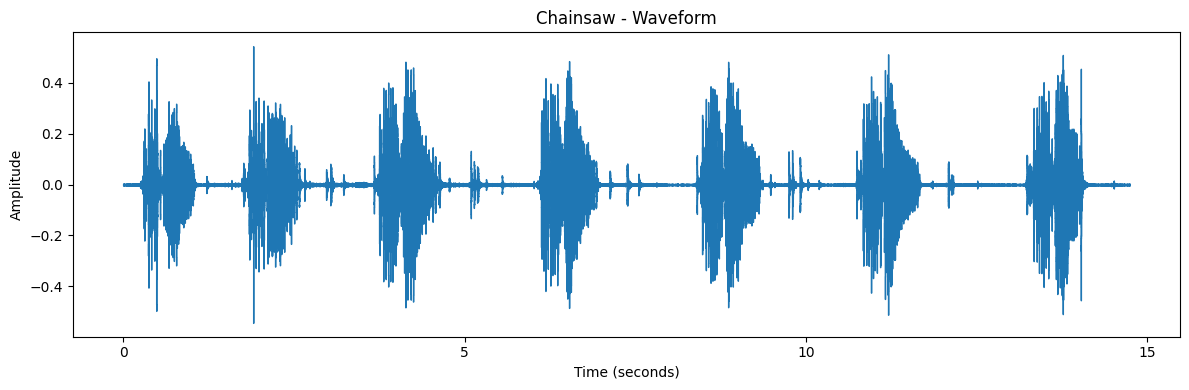

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

BASE_DIR = r"D:\illegal-logging-detector"
DATA_DIR = os.path.join(BASE_DIR, "data", "raw")

# Load one chainsaw clip
chainsaw_folder = os.path.join(DATA_DIR, "chainsaw")
sample_file = os.path.join(chainsaw_folder, os.listdir(chainsaw_folder)[0])

print(f"Loading: {sample_file}")

# Load audio
audio, sr = librosa.load(sample_file, sr=22050)

print(f"✅ Sample rate: {sr} Hz")
print(f"✅ Duration: {len(audio)/sr:.2f} seconds")
print(f"✅ Audio shape: {audio.shape}")

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Chainsaw - Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

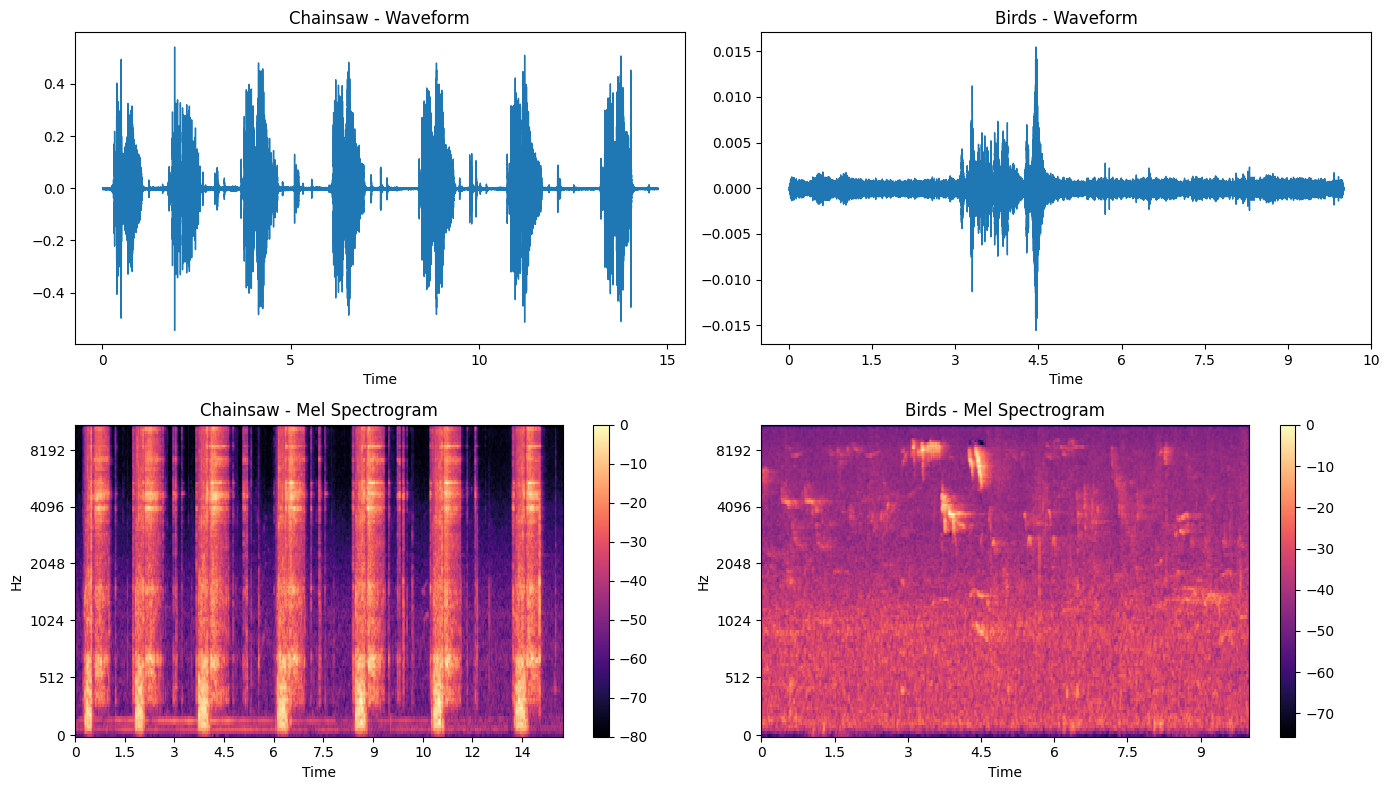

✅ Top row = raw waveforms
✅ Bottom row = mel spectrograms (this is what your model will see)


In [2]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Load chainsaw
chainsaw_file = os.path.join(DATA_DIR, "chainsaw", os.listdir(os.path.join(DATA_DIR, "chainsaw"))[0])
chainsaw_audio, sr = librosa.load(chainsaw_file, sr=22050)

# Load birds
birds_file = os.path.join(DATA_DIR, "birds", os.listdir(os.path.join(DATA_DIR, "birds"))[0])
birds_audio, _ = librosa.load(birds_file, sr=22050)

# Chainsaw waveform
axes[0,0].set_title("Chainsaw - Waveform")
librosa.display.waveshow(chainsaw_audio, sr=sr, ax=axes[0,0])

# Birds waveform
axes[0,1].set_title("Birds - Waveform")
librosa.display.waveshow(birds_audio, sr=sr, ax=axes[0,1])

# Chainsaw spectrogram
chainsaw_mel = librosa.feature.melspectrogram(y=chainsaw_audio, sr=sr, n_mels=128)
chainsaw_db = librosa.power_to_db(chainsaw_mel, ref=np.max)
img1 = librosa.display.specshow(chainsaw_db, sr=sr, x_axis="time", y_axis="mel", ax=axes[1,0])
axes[1,0].set_title("Chainsaw - Mel Spectrogram")
fig.colorbar(img1, ax=axes[1,0])

# Birds spectrogram
birds_mel = librosa.feature.melspectrogram(y=birds_audio, sr=sr, n_mels=128)
birds_db = librosa.power_to_db(birds_mel, ref=np.max)
img2 = librosa.display.specshow(birds_db, sr=sr, x_axis="time", y_axis="mel", ax=axes[1,1])
axes[1,1].set_title("Birds - Mel Spectrogram")
fig.colorbar(img2, ax=axes[1,1])

plt.tight_layout()
plt.show()

print("✅ Top row = raw waveforms")
print("✅ Bottom row = mel spectrograms (this is what your model will see)")

In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

BASE_DIR = r"D:\illegal-logging-detector"
DATA_DIR = os.path.join(BASE_DIR, "data", "raw")
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")

# Settings
SR = 22050          # sample rate
DURATION = 5        # seconds per clip
N_MELS = 128        # mel bands
HOP_LENGTH = 512    # hop length
N_FFT = 2048        # FFT window size

# Logging vs non logging categories
LOGGING_CATS = ["chainsaw", "truck", "machinery"]
FOREST_CATS  = ["birds", "rain", "wind", "forest_ambience"]

def audio_to_melspectrogram(file_path):
    try:
        # Load and fix duration to exactly 5 seconds
        audio, sr = librosa.load(file_path, sr=SR, duration=DURATION)
        
        # Pad if shorter than 5 seconds
        target_length = SR * DURATION
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        
        # Convert to mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=audio, sr=sr,
            n_mels=N_MELS,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)
        
        # Normalize to 0-1
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
        
        return mel_db
    
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# Create output folders
for split in ["train", "val", "test"]:
    for label in ["logging", "non_logging"]:
        os.makedirs(os.path.join(PROCESSED_DIR, split, label), exist_ok=True)

print("✅ Output folders created")
print(f"✅ Settings: SR={SR}, Duration={DURATION}s, Mels={N_MELS}")
print("\nReady to process all 210 clips...")

✅ Output folders created
✅ Settings: SR=22050, Duration=5s, Mels=128

Ready to process all 210 clips...


In [4]:
from sklearn.model_selection import train_test_split

# Collect all file paths and labels
all_files = []
all_labels = []

for cat in LOGGING_CATS:
    folder = os.path.join(DATA_DIR, cat)
    for f in os.listdir(folder):
        if f.endswith(".mp3"):
            all_files.append(os.path.join(folder, f))
            all_labels.append("logging")

for cat in FOREST_CATS:
    folder = os.path.join(DATA_DIR, cat)
    for f in os.listdir(folder):
        if f.endswith(".mp3"):
            all_files.append(os.path.join(folder, f))
            all_labels.append("non_logging")

print(f"✅ Total files found: {len(all_files)}")
print(f"✅ Logging clips: {all_labels.count('logging')}")
print(f"✅ Non logging clips: {all_labels.count('non_logging')}")

# Split into train 70% / val 15% / test 15%
X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ Train: {len(X_train)} clips")
print(f"✅ Val:   {len(X_val)} clips")
print(f"✅ Test:  {len(X_test)} clips")

# Process and save all clips
def process_and_save(files, labels, split_name):
    print(f"\n📂 Processing {split_name} set...")
    saved = 0
    failed = 0
    
    for file_path, label in tqdm(zip(files, labels), total=len(files)):
        mel = audio_to_melspectrogram(file_path)
        
        if mel is None:
            failed += 1
            continue
        
        # Save as numpy array
        filename = os.path.basename(file_path).replace(".mp3", ".npy")
        save_path = os.path.join(PROCESSED_DIR, split_name, label, filename)
        np.save(save_path, mel)
        saved += 1
    
    print(f"✅ {split_name}: {saved} saved, {failed} failed")

process_and_save(X_train, y_train, "train")
process_and_save(X_val, y_val, "val")
process_and_save(X_test, y_test, "test")

print("\n🎉 All clips processed and saved!")

✅ Total files found: 210
✅ Logging clips: 90
✅ Non logging clips: 120

✅ Train: 147 clips
✅ Val:   31 clips
✅ Test:  32 clips

📂 Processing train set...


100%|██████████| 147/147 [00:04<00:00, 31.02it/s]


✅ train: 147 saved, 0 failed

📂 Processing val set...


100%|██████████| 31/31 [00:00<00:00, 44.09it/s]


✅ val: 31 saved, 0 failed

📂 Processing test set...


100%|██████████| 32/32 [00:00<00:00, 44.21it/s]

✅ test: 32 saved, 0 failed

🎉 All clips processed and saved!


✅ Shape: (128, 216)
✅ Min value: 0.000
✅ Max value: 1.000
✅ Data type: float32


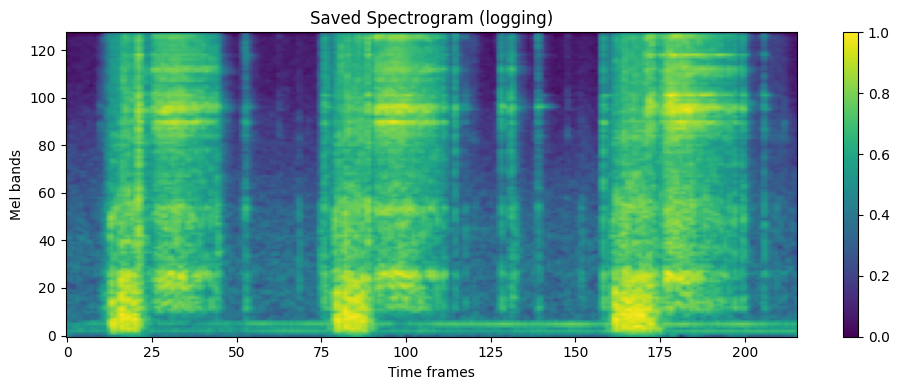

In [5]:
# Load one saved spectrogram and visualize it
sample_path = os.path.join(PROCESSED_DIR, "train", "logging", 
              os.listdir(os.path.join(PROCESSED_DIR, "train", "logging"))[0])

sample = np.load(sample_path)

print(f"✅ Shape: {sample.shape}")
print(f"✅ Min value: {sample.min():.3f}")
print(f"✅ Max value: {sample.max():.3f}")
print(f"✅ Data type: {sample.dtype}")

plt.figure(figsize=(10, 4))
plt.imshow(sample, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar()
plt.title("Saved Spectrogram (logging)")
plt.xlabel("Time frames")
plt.ylabel("Mel bands")
plt.tight_layout()
plt.show()

In [6]:
import random
import numpy as np
from tqdm import tqdm

AUGMENTED_DIR = os.path.join(BASE_DIR, "data", "augmented")
os.makedirs(os.path.join(AUGMENTED_DIR, "logging"), exist_ok=True)
os.makedirs(os.path.join(AUGMENTED_DIR, "non_logging"), exist_ok=True)

def augment_spectrogram(mel):
    augmented = []
    
    # 1. Time masking - block out random time sections
    aug1 = mel.copy()
    t_start = random.randint(0, mel.shape[1] - 30)
    aug1[:, t_start:t_start+30] = 0
    augmented.append(aug1)
    
    # 2. Frequency masking - block out random frequency bands
    aug2 = mel.copy()
    f_start = random.randint(0, mel.shape[0] - 20)
    aug2[f_start:f_start+20, :] = 0
    augmented.append(aug2)
    
    # 3. Add gaussian noise
    aug3 = mel.copy()
    noise = np.random.normal(0, 0.02, mel.shape)
    aug3 = np.clip(aug3 + noise, 0, 1)
    augmented.append(aug3)
    
    # 4. Time shift - roll the spectrogram horizontally
    aug4 = mel.copy()
    shift = random.randint(10, 50)
    aug4 = np.roll(aug4, shift, axis=1)
    augmented.append(aug4)
    
    return augmented

# Augment training data only
for label in ["logging", "non_logging"]:
    train_folder = os.path.join(PROCESSED_DIR, "train", label)
    aug_folder = os.path.join(AUGMENTED_DIR, label)
    files = os.listdir(train_folder)
    
    print(f"\n📂 Augmenting {label} ({len(files)} clips → {len(files)*5} total)")
    
    saved = 0
    for fname in tqdm(files):
        # Save original first
        mel = np.load(os.path.join(train_folder, fname))
        np.save(os.path.join(aug_folder, fname), mel)
        saved += 1
        
        # Save 4 augmented versions
        augmented = augment_spectrogram(mel)
        for i, aug in enumerate(augmented):
            aug_fname = fname.replace(".npy", f"_aug{i}.npy")
            np.save(os.path.join(aug_folder, aug_fname), aug)
            saved += 1
    
    print(f"✅ {label}: {saved} total clips after augmentation")

print("\n🎉 Augmentation complete!")


📂 Augmenting logging (63 clips → 315 total)


100%|██████████| 63/63 [00:02<00:00, 24.51it/s]


✅ logging: 315 total clips after augmentation

📂 Augmenting non_logging (84 clips → 420 total)


100%|██████████| 84/84 [00:01<00:00, 53.11it/s]

✅ non_logging: 420 total clips after augmentation

🎉 Augmentation complete!
